# Linear regression

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import sys
sys.path.insert(0,'../')

In [2]:
from itertools import product

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.optimize import lsq_linear
from tqdm.auto import trange, tqdm

from system_identification.lsqr_model import LeastSquaresModel

In [3]:
data = xr.open_dataset("data/data_smoothed.nc")
data

<xarray.Dataset>
Dimensions:                 (t: 10001, dim_0: 4, dim_1: 4, x_idx: 4,
                             all_samples: 10001, inputs: 2, m: 1, outputs: 1,
                             training_samples: 7001, validation_samples: 3000,
                             d0: 2, d1: 2)
Coordinates:
  * t                       (t) float64 0.0 0.01 0.02 0.03 ... 99.98 99.99 100.0
Dimensions without coordinates: dim_0, dim_1, x_idx, all_samples, inputs, m,
                                outputs, training_samples, validation_samples,
                                d0, d1
Data variables: (12/42)
    p_k1k1                  (t, dim_0, dim_1) float64 ...
    p_kk1                   (t, dim_0, dim_1) float64 ...
    phi                     (t, dim_0, dim_1) float64 ...
    gamma                   (t, dim_0, dim_1) float64 ...
    ps                      (t, dim_0, dim_1) float64 ...
    x_k1k1                  (t, x_idx) float64 ...
    ...                      ...
    alpha_estimate          (t) float64 ...
    training_inputs         (training_samples, inputs, m) float64 ...
    training_outputs        (training_samples, outputs, m) float64 ...
    validation_inputs       (validation_samples, inputs, m) float64 ...
    validation_outputs      (validation_samples, outputs, m) float64 ...
    input_range             (d0, d1) float64 ...

In [4]:
orders = list(range(1, 50, 1))

error_training_mean = []
error_training_abs_mean = []
error_training_jb = []
error_training_jbp = []
error_validation_mean = []
error_validation_abs_mean = []
error_validation_jb = []
error_validation_jbp = []

models = []

for order in tqdm(orders):
    model = LeastSquaresModel.new_polynomial(
        n_inputs=2,
        input_range=data.input_range.values,
        order=order)
    models.append(model)

    model.train(
        inputs=data.training_inputs.values,
        reference_outputs=data.training_outputs.values,
        validation_inputs=data.validation_inputs.values,
        validation_outputs=data.validation_outputs.values,
    )
    
    error_training_mean.append(abs(model.training_log.error_training_data).mean())
    error_training_abs_mean.append(model.training_log.error_training_data.mean())
    error_training_jb.append(model.training_log.error_training_jb.item())
    error_training_jbp.append(model.training_log.error_training_jbp.item())
    
    error_validation_mean.append(abs(model.training_log.error_validation_data).mean())
    error_validation_abs_mean.append(model.training_log.error_validation_data.mean())
    error_validation_jb.append(model.training_log.error_validation_jb.item())
    error_validation_jbp.append(model.training_log.error_validation_jbp.item())
    
    

  0%|          | 0/49 [00:00<?, ?it/s]

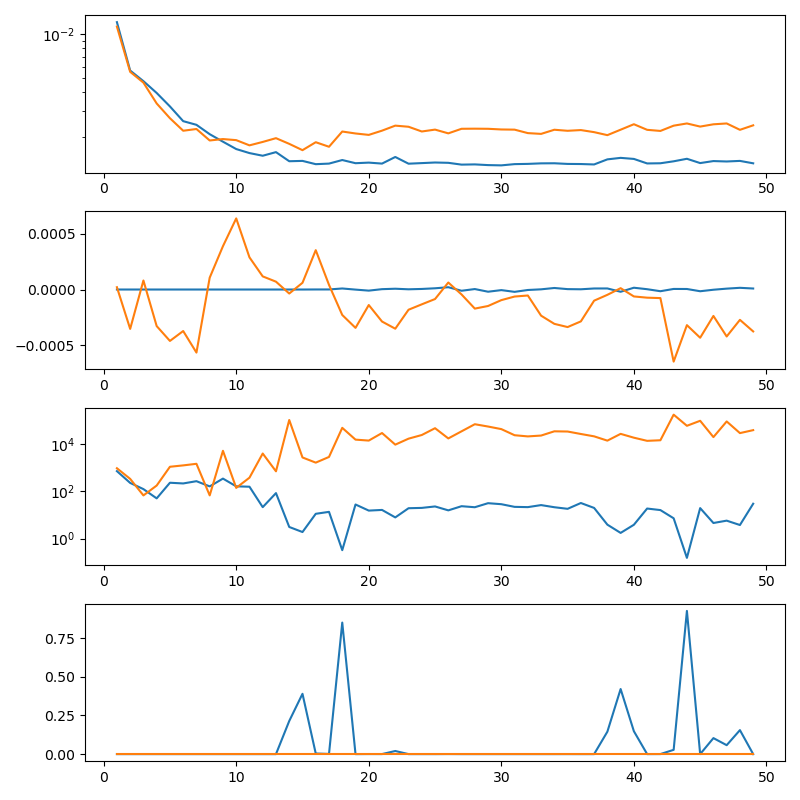

In [5]:
fig, axs = plt.subplots(4, 1, figsize=(8, 8))

axs[0].set_yscale("log")
axs[0].plot(orders, error_training_mean)
axs[0].plot(orders, error_validation_mean)

axs[1].plot(orders, error_training_abs_mean)
axs[1].plot(orders, error_validation_abs_mean)

axs[2].set_yscale("log")
axs[2].plot(orders, error_training_jb)
axs[2].plot(orders, error_validation_jb)

axs[3].plot(orders, error_training_jbp)
axs[3].plot(orders, error_validation_jbp)

plt.tight_layout()

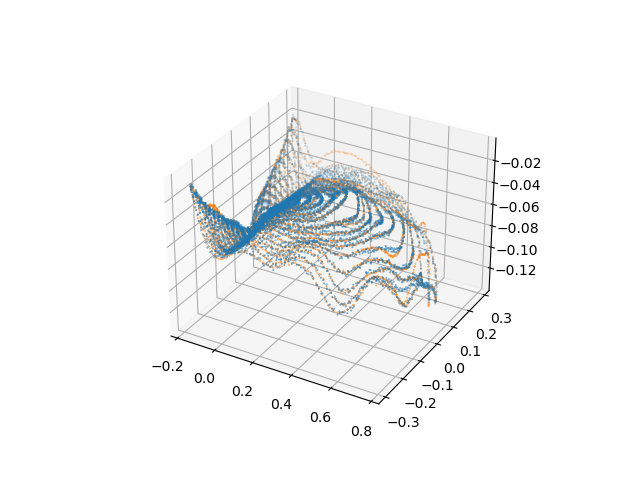

In [6]:
fig = plt.figure()

reference_inputs = data.all_inputs.values
reference_outputs = data.all_outputs.values

output = model.evaluate(reference_inputs)
ax = fig.add_subplot(projection='3d')
ax.scatter(reference_inputs[:, 0, 0], reference_inputs[:, 1, 0], reference_outputs.squeeze(), s=0.1)
ax.scatter(reference_inputs[:, 0, 0], reference_inputs[:, 1, 0], output.squeeze(), s=0.1)

In [7]:
model.training_log

<xarray.Dataset>
Dimensions:                (epoch: 1, i: 7001, j: 3000, k: 2500)
Coordinates:
  * epoch                  (epoch) int64 1
Dimensions without coordinates: i, j, k
Data variables: (12/14)
    gradient               (epoch) float64 nan
    error_training_data    (epoch, i) float64 0.002073 0.001196 ... 0.002589
    error_validation_data  (epoch, j) float64 -0.001358 0.001828 ... 0.005198
    error_training_jb      (epoch) float64 29.58
    error_training_jbp     (epoch) float64 3.773e-07
    error_training_skew    (epoch) float64 -0.007811
    ...                     ...
    error_validation_jbp   (epoch) float64 0.0
    error_validation_skew  (epoch) float64 -2.929
    error_validation_kurt  (epoch) float64 19.44
    coefficients           (epoch, k) float64 -0.05968 0.00739 ... 1.491e-20
    min_residual_epoch     int64 1
    min_jb_epoch           int64 1